In [1]:
import tensorflow as tf
import keras

RANDOM_SEED = 42

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from pandas.plotting import register_matplotlib_converters

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [3]:
# ff = pd.read_csv('stackfootfall.csv',  parse_dates=['timestamp'])

In [4]:
ff = pd.read_csv('stackfootfall.csv')
ff.timestamp = pd.to_datetime(ff.timestamp, format = '%Y-%m-%d %H:%M:%S')

In [5]:
loc = 639
ff639 = ff.loc[(ff.location <= loc) & (ff.location >= loc) & (ff.timestamp >= '2018-01') & 
               (ff.timestamp <= '2019-08-18 23:00')][['timestamp','footfall']]

temp = ff639
temp['month'] = temp.timestamp.dt.month
temp['day'] = temp.timestamp.dt.day
temp['hour'] = temp.timestamp.dt.hour
temp['day_of_week'] = temp.timestamp.dt.dayofweek + 1

temp.index = temp.timestamp
temp = temp.drop(['timestamp'], axis=1)

In [6]:
train = temp.loc[(temp.index >= '2018-01-01 00:00') & (temp.index <= '2019-07-28 23:00')]
test = temp.loc[(temp.index >= '2019-07-29 00:00') & (temp.index <= '2019-08-18 23:00')]

In [7]:
train

,footfall,month,day,hour,day_of_week
timestamp,,,,,
2018-01-01 00:00:00,129.0,1,1,0,1
2018-01-01 01:00:00,127.0,1,1,1,1
2018-01-01 02:00:00,121.0,1,1,2,1
2018-01-01 03:00:00,110.0,1,1,3,1
2018-01-01 04:00:00,83.0,1,1,4,1
...,...,...,...,...,...
2019-07-28 19:00:00,212.0,7,28,19,7
2019-07-28 20:00:00,140.0,7,28,20,7
2019-07-28 21:00:00,139.0,7,28,21,7


In [8]:
from sklearn.preprocessing import RobustScaler

ff_transformer = RobustScaler()
ff_transformer = ff_transformer.fit(train[['footfall']])

train['footfall'] = ff_transformer.transform(train[['footfall']])
test['footfall'] = ff_transformer.transform(test[['footfall']])

E:\Anaconda3\envs\urbsim\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
E:\Anaconda3\envs\urbsim\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [9]:
def create_dataset(X, y, time_steps = 1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [10]:
time_steps = 10

# reshape to [samples, time_steps, n_features]

X_train, y_train = create_dataset(train, train.footfall, time_steps)
X_test, y_test = create_dataset(test, test.footfall, time_steps)

print(X_train.shape, y_train.shape)

(13622, 10, 5) (13622,)


In [11]:
model = keras.Sequential()
model.add(
  keras.layers.Bidirectional(
    keras.layers.LSTM(
      units=128, 
      input_shape=(X_train.shape[1], X_train.shape[2])
    )
  )
)
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(units=1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [12]:
X_train[0][0]

array([-0.33235294,  1.        ,  1.        ,  0.        ,  1.        ])

In [13]:
y_train

array([-0.28529412, -0.17352941,  0.12941176, ..., -0.30294118,
       -0.42352941, -0.47058824])

In [14]:
history = model.fit(
    X_train, y_train, 
    epochs=30, 
    batch_size=32, 
    validation_split=0.1,
    shuffle=False
)

Epoch 1/30
384/384 [==============================] - 5s 12ms/step - loss: 0.1617 - val_loss: 0.0433
Epoch 2/30
384/384 [==============================] - 4s 10ms/step - loss: 0.0567 - val_loss: 0.0375
Epoch 3/30
384/384 [==============================] - 4s 11ms/step - loss: 0.0399 - val_loss: 0.0464
Epoch 4/30
384/384 [==============================] - 4s 10ms/step - loss: 0.0323 - val_loss: 0.0292
Epoch 5/30
384/384 [==============================] - 4s 11ms/step - loss: 0.0285 - val_loss: 0.0377
Epoch 6/30
384/384 [==============================] - 4s 10ms/step - loss: 0.0250 - val_loss: 0.0320
Epoch 7/30
384/384 [==============================] - 4s 11ms/step - loss: 0.0228 - val_loss: 0.0290
Epoch 8/30
384/384 [==============================] - 4s 11ms/step - loss: 0.0222 - val_loss: 0.0256
Epoch 9/30
384/384 [==============================] - 4s 11ms/step - loss: 0.0203 - val_loss: 0.0237
Epoch 10/30
384/384 [==============================] - 4s 11ms/step - loss: 0.0196 - val_lo

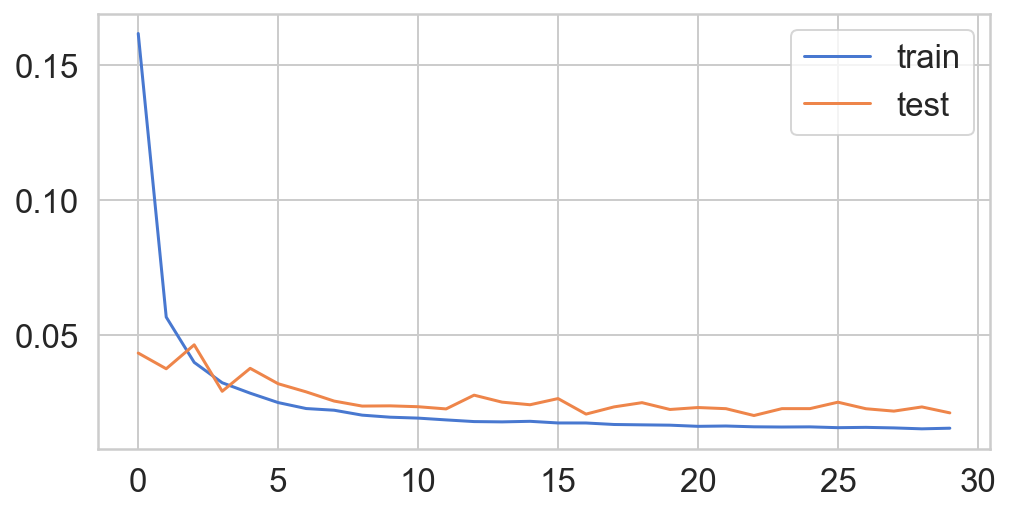

In [19]:
plt.figure(figsize = (8,4))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

In [15]:
y_pred = model.predict(X_test)

In [16]:
y_train_inv = ff_transformer.inverse_transform(y_train.reshape(1, -1))
y_test_inv = ff_transformer.inverse_transform(y_test.reshape(1, -1))
y_pred_inv = ff_transformer.inverse_transform(y_pred)

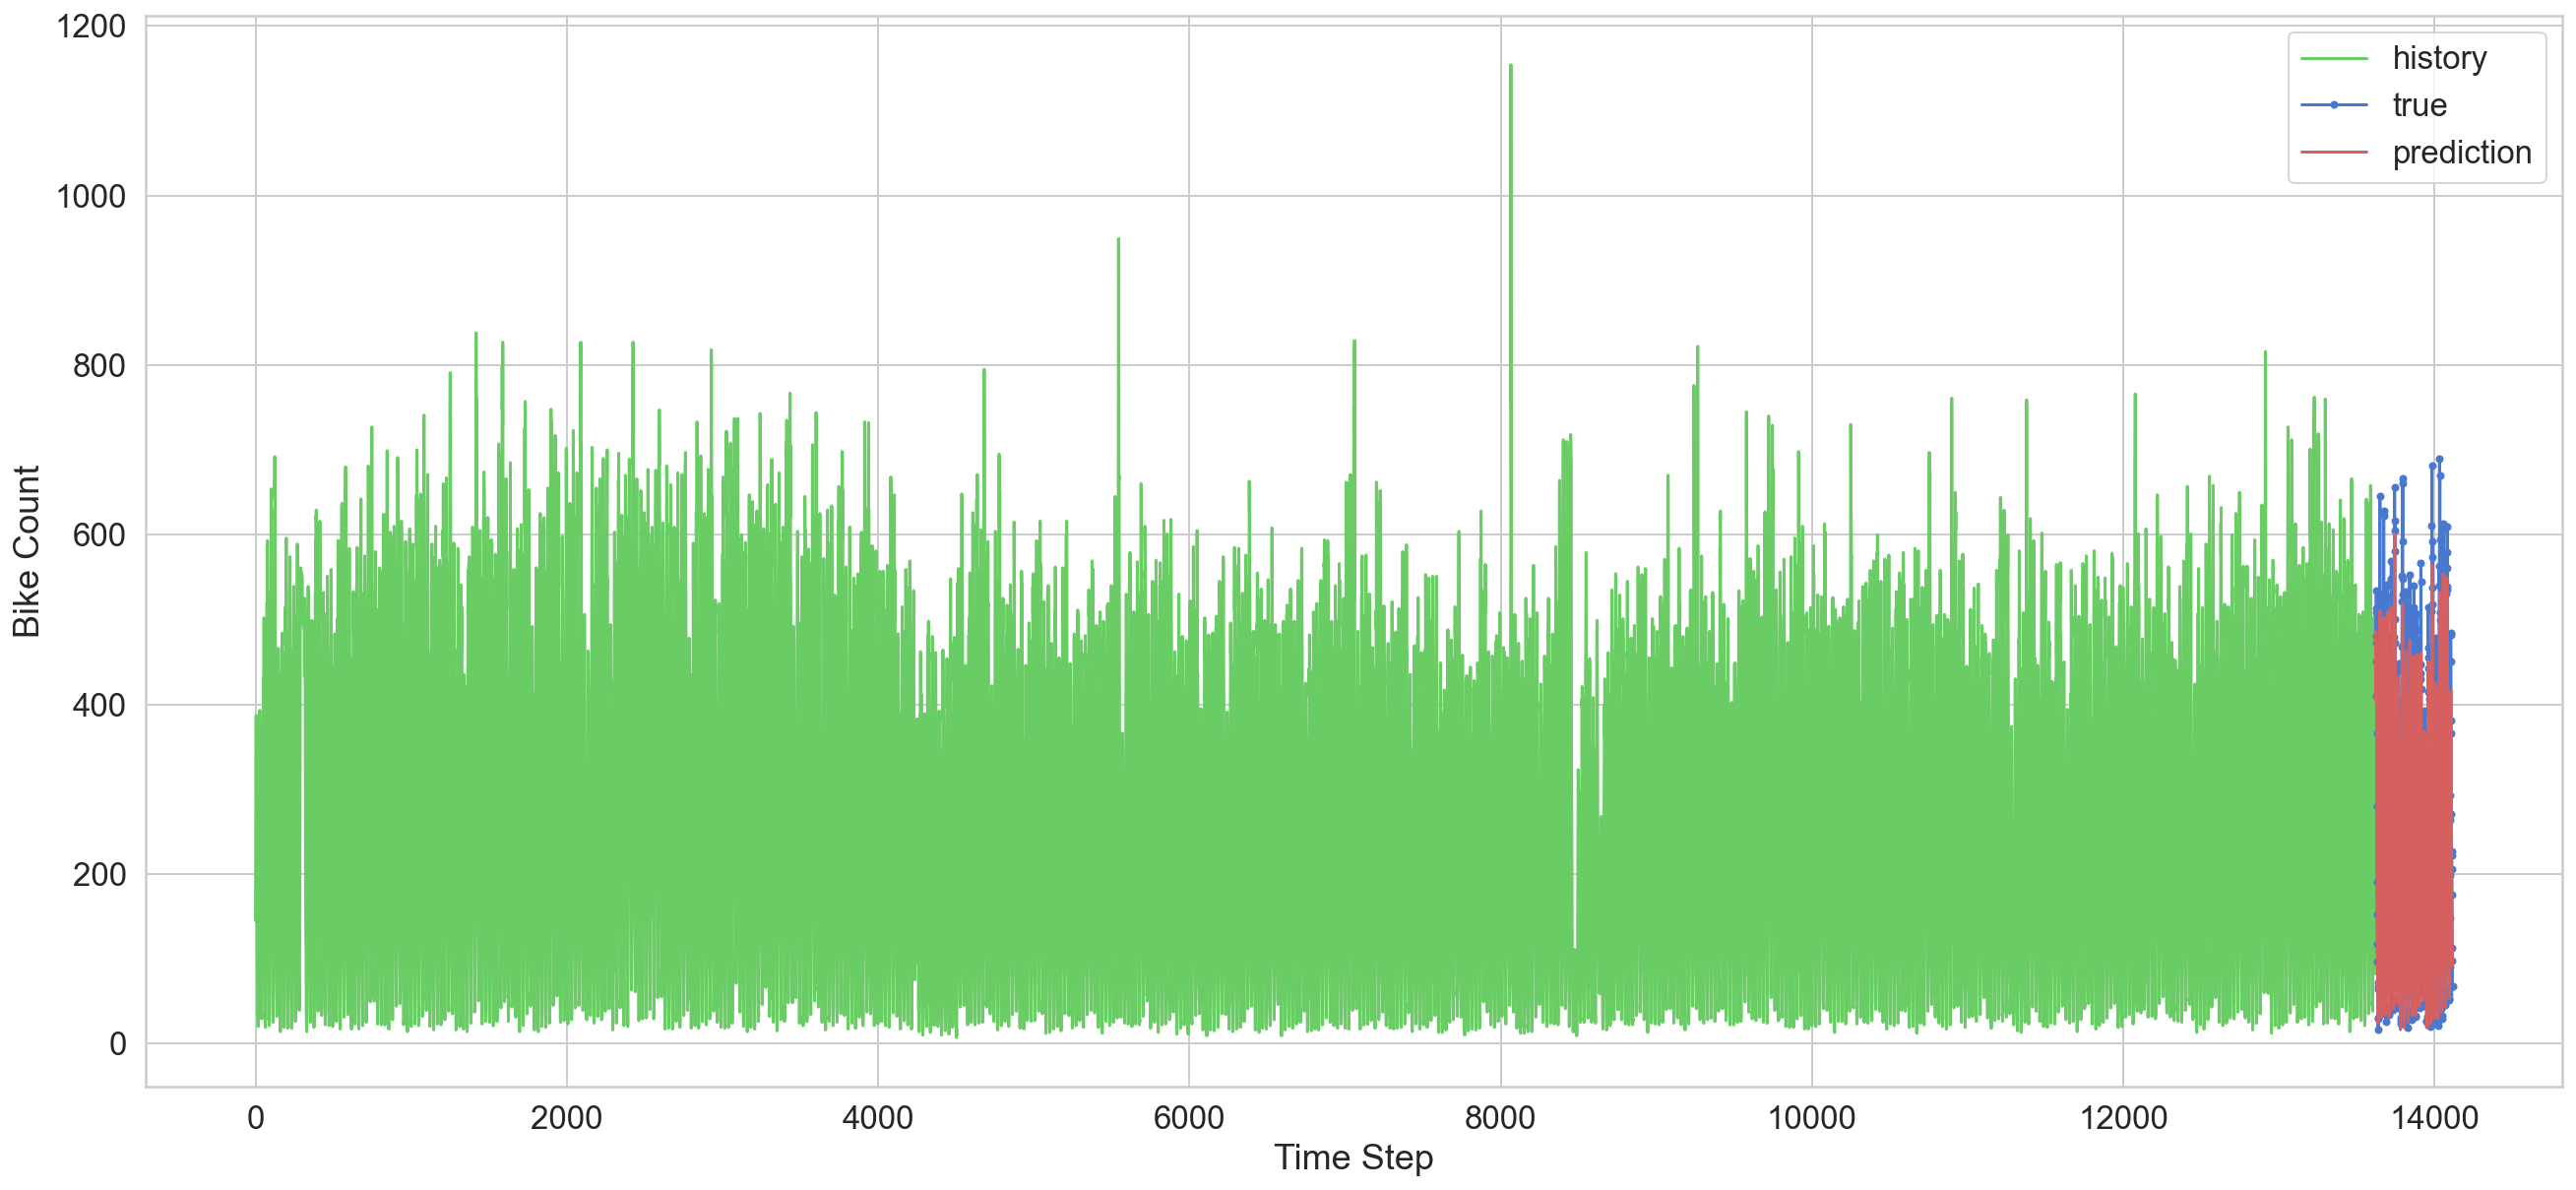

In [17]:
plt.plot(np.arange(0, len(y_train)), y_train_inv.flatten(), 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test_inv.flatten(), marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred_inv.flatten(), 'r', label="prediction")
plt.ylabel('Bike Count')
plt.xlabel('Time Step')
plt.legend()
plt.show();

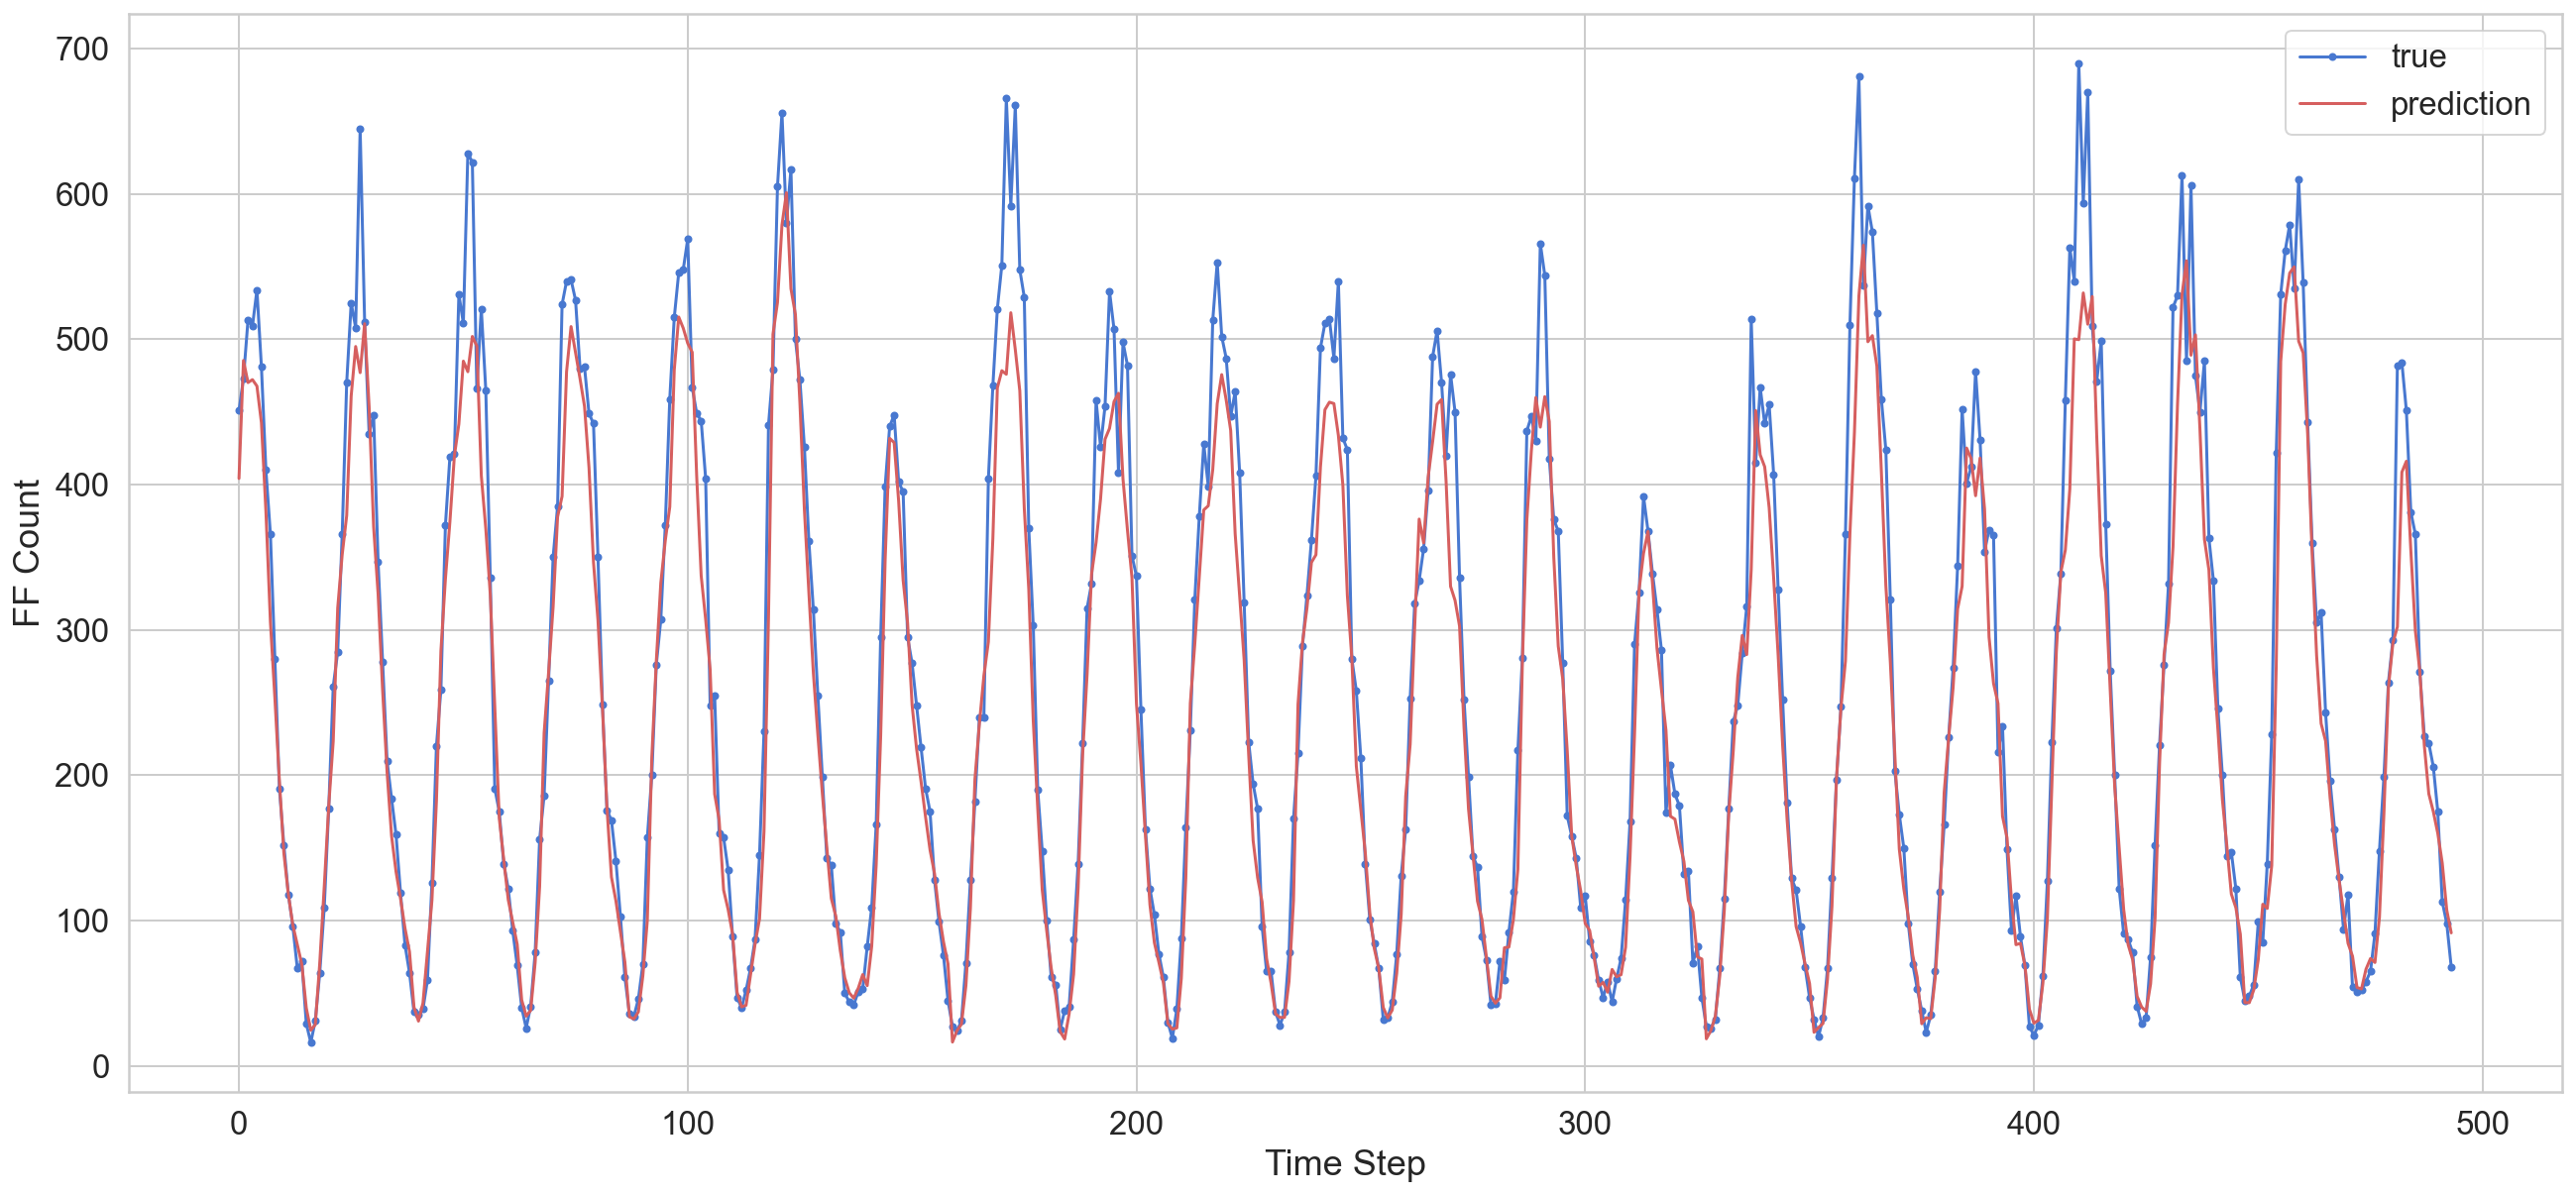

In [18]:
plt.plot(y_test_inv.flatten(), marker='.', label="true")
plt.plot(y_pred_inv.flatten(), 'r', label="prediction")
plt.ylabel('FF Count')
plt.xlabel('Time Step')
plt.legend()
plt.show();

In [10]:
from math import sqrt

def rmse(y_true, y_pred):
    squared_error = 0
    for i in range(len(y_true)):
        squared_error = squared_error + (y_true[i] - y_pred[i]) ** 2
    root_mean_squared_error = sqrt(squared_error / len(y_true))
    return root_mean_squared_error

In [22]:
lstm_rmse = rmse(y_test_inv.flatten(), y_pred_inv.flatten())
lstm_rmse

50.69065705828996

In [5]:
from sklearn.preprocessing import RobustScaler

In [6]:
ff = pd.read_csv('stackfootfall.csv')
ff.timestamp = pd.to_datetime(ff.timestamp, format = '%Y-%m-%d %H:%M:%S') 

ff = ff.loc[(ff.timestamp >= '2018-01') & (ff.timestamp <= '2019-08-18 23:00')]

ff_count = ff.groupby('location')['footfall'].count() / max(ff.groupby('location')['footfall'].count())
limit1 = ff_count.loc[ff_count >= 0.6].to_frame()
ff_test = ff.loc[(ff.timestamp >= '2018-07-29') & (ff.timestamp <= '2019-08-18 23:00')]
ff_test_count = ff_test.groupby('location')['footfall'].count() / max(ff_test.groupby('location')['footfall'].count())
limit2 = ff_test_count.loc[ff_test_count >= 0.8].to_frame()
limit = pd.merge(limit1, limit2, how = 'inner', on = 'location')

ff = pd.merge(ff, limit, how = 'inner', on = 'location')

In [9]:
loc = 91
ff_loc = ff.loc[(ff.location <= loc) & (ff.location >= loc)][[
        'timestamp','footfall','year','month','day','hour','day_of_week']]    
ff_loc.index = ff_loc.timestamp
ff_loc = ff_loc.resample('H').mean()

ff_loc['footfall'].replace(0, np.nan, inplace = True)
ff_loc['footfall'] = ff_loc['footfall'].interpolate(method='linear')
ff_loc = ff_loc.reset_index(level = ['timestamp'])
ff_loc.timestamp = pd.to_datetime(ff_loc.timestamp, format = '%Y-%m-%d %H:%M:%S')

temp = ff_loc[['timestamp', 'footfall']]
temp.index = temp.timestamp
temp['year'] = temp.timestamp.dt.year
temp['month'] = temp.timestamp.dt.month
temp['day'] = temp.timestamp.dt.day
temp['hour'] = temp.timestamp.dt.hour
temp['day_of_week'] = temp.timestamp.dt.dayofweek + 1

train = temp.loc[(temp.timestamp >= '2018-01-01 00:00') & (temp.timestamp <= '2019-07-28 23:00')][[
    'footfall','month','day','hour','day_of_week']]
test = temp.loc[(temp.timestamp >= '2019-07-29 00:00') & (temp.timestamp <= '2019-08-18 23:00')][[
    'footfall','month','day','hour','day_of_week']]  

ff_transformer = RobustScaler()
ff_transformer = ff_transformer.fit(train[['footfall']])

train['footfall'] = ff_transformer.transform(train[['footfall']])
test['footfall'] = ff_transformer.transform(test[['footfall']])

time_steps = 24
X_train, y_train = create_dataset(train, train.footfall, time_steps)
X_test, y_test = create_dataset(test, test.footfall, time_steps)

model = keras.Sequential()
model.add(
  keras.layers.Bidirectional(
    keras.layers.LSTM(
      units=128, 
      input_shape=(X_train.shape[1], X_train.shape[2])
    )
  )
)
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(units=1))
model.compile(loss='mean_squared_error', optimizer='adam')    

history = model.fit(
X_train, y_train, 
epochs=30, 
batch_size=32, 
validation_split=0.1,
shuffle=False
)

y_pred = model.predict(X_test)

y_train_inv = ff_transformer.inverse_transform(y_train.reshape(1, -1))
y_test_inv = ff_transformer.inverse_transform(y_test.reshape(1, -1))
y_pred_inv = ff_transformer.inverse_transform(y_pred)

E:\Anaconda3\envs\urbsim\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
E:\Anaconda3\envs\urbsim\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
E:\Anaconda3\envs\urbsim\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

Epoch 1/30
387/387 [==============================] - 8s 20ms/step - loss: 0.3035 - val_loss: 0.1915
Epoch 2/30
387/387 [==============================] - 7s 19ms/step - loss: 0.1379 - val_loss: 0.0861
Epoch 3/30
387/387 [==============================] - 8s 21ms/step - loss: 0.1019 - val_loss: 0.0698
Epoch 4/30
387/387 [==============================] - 8s 20ms/step - loss: 0.0858 - val_loss: 0.0595
Epoch 5/30
387/387 [==============================] - 7s 18ms/step - loss: 0.0760 - val_loss: 0.0581
Epoch 6/30
387/387 [==============================] - 7s 18ms/step - loss: 0.0695 - val_loss: 0.0560
Epoch 7/30
387/387 [==============================] - 7s 18ms/step - loss: 0.0624 - val_loss: 0.0492
Epoch 8/30
387/387 [==============================] - 7s 17ms/step - loss: 0.0577 - val_loss: 0.0513
Epoch 9/30
387/387 [==============================] - 7s 17ms/step - loss: 0.0561 - val_loss: 0.0479
Epoch 10/30
387/387 [==============================] - 7s 18ms/step - loss: 0.0519 - val_lo

NameError: name 'rmse' is not defined

In [11]:
lstm_rmse = rmse(y_test_inv.flatten(), y_pred_inv.flatten())

lstm_rmse

122.6432239149512